In [1]:
import networkx as nx
import pandas as pd 
import numpy as np
import os
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

### Preprocess

In [2]:
fsx = pd.read_csv(r'C:\Users\efeka\Documents\GitHub\MIND\mind_adni1_bl\UCSFFSX_11_02_15_09Apr2025.csv')
tadpole = pd.read_csv(r'C:\Users\efeka\Documents\GitHub\gnn-healthcare-thesis\imputation\TADPOLE_D1_D2_sorted_imputed.csv')

csv_dir = 'mind_adni1_bl/MIND_filtered_vertices/'
graph_dir = csv_dir + 'nx/'
ptids = []
rids = []
labels = []
for fname in os.listdir(graph_dir):
    if fname.endswith('.pickle'):
        ptid = fname.replace('.pickle', '')
        ptids.append(ptid)
        rid = tadpole[tadpole['PTID'] == ptid]['RID'].values[0]
        rids.append(rid)
        label = tadpole[tadpole['PTID'] == ptid ]['DX_bl'].values[0]
        labels.append(label)

# fsx sc visits 
fsx_adni1_bl = fsx[fsx['RID'].isin(rids)]
fsx_adni1_bl = fsx_adni1_bl[fsx_adni1_bl['VISCODE'] == 'sc']


In [3]:
# Initial feature selection
features = [
    column for column in fsx_adni1_bl.columns 
    if ('ST' in column and ('TA' in column or 'TS' in column or 'SV' in column or 'SA' in column or 'CV' in column))
]
features.remove('STATUS')

# Drop features that have any missing values (i.e. not fully observed across all patients)
fully_observed_features = [f for f in features if not fsx_adni1_bl[f].isna().any()]
features = fully_observed_features


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


X_list = []
y_list = []

for rid, label in zip(rids, labels):
    # Filter to the row in fsx_adni1_bl matching this RID
    row = fsx_adni1_bl[fsx_adni1_bl['RID'] == rid]

    # If we don't find exactly one row or if any feature is missing, skip it
    if row.shape[0] != 1:
        continue
    
    row_values = row[features].values.squeeze()

    # If any value in the feature vector is NaN, skip this RID
    if np.isnan(row_values).any():
        continue

    X_list.append(row_values)
    y_list.append(label)

# Convert to NumPy arrays
X = np.array(X_list)
y = np.array(y_list)


le = LabelEncoder()
y_encoded = le.fit_transform(y)

## 3-class

### Logistic Regression

In [ ]:


# Logistic Regression with class_weight to handle imbalance
# clf = LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0)
clf = LogisticRegression(max_iter=2000, C=1.0, penalty='l2', verbose=0)

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_all = []
y_true_all = []
y_train_all = []
y_train_pred_all = []

for train_idx, val_idx in skf.split(X, y_encoded):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_val)
    y_train_pred = clf.predict(X_train)
    
    y_pred_all.extend(y_pred)
    y_true_all.extend(y_val)
    
    y_train_all.extend(y_train)
    y_train_pred_all.extend(y_train_pred)

# Print classification report
print("Validation Set Classification Report (Cross-Validated):")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

print("\nTraining Set Classification Report (Cross-Validated):")
print(classification_report(y_train_all, y_train_pred_all, target_names=le.classes_))


c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Validation Set Classification Report (Cross-Validated):
              precision    recall  f1-score   support

          AD       0.47      0.39      0.43       188
          CN       0.59      0.57      0.58       224
        LMCI       0.55      0.60      0.57       388

    accuracy                           0.54       800
   macro avg       0.54      0.52      0.53       800
weighted avg       0.54      0.54      0.54       800


Training Set Classification Report (Cross-Validated):
              precision    recall  f1-score   support

          AD       0.74      0.64      0.69       752
          CN       0.74      0.72      0.73       896
        LMCI       0.71      0.77      0.74      1552

    accuracy                           0.73      3200
   macro avg       0.73      0.71      0.72      3200
weighted avg       0.73      0.73      0.73      3200



c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with class balancing
clf = RandomForestClassifier(
    n_estimators=50,         # number of trees
    # class_weight='balanced',  # handle class imbalance
    random_state=42,
    max_depth=5,
    n_jobs=-1                 # use all CPUs
)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_all = []
y_true_all = []
y_train_all = []
y_train_pred_all = []

for train_idx, val_idx in skf.split(X, y_encoded):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    y_train_pred = clf.predict(X_train)

    y_pred_all.extend(y_pred)
    y_true_all.extend(y_val)

    y_train_all.extend(y_train)
    y_train_pred_all.extend(y_train_pred)

# Print results
print("Validation Set Classification Report (Cross-Validated):")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

print("\nTraining Set Classification Report (Cross-Validated):")
print(classification_report(y_train_all, y_train_pred_all, target_names=le.classes_))


Validation Set Classification Report (Cross-Validated):
              precision    recall  f1-score   support

          AD       0.54      0.59      0.57       188
          CN       0.55      0.71      0.62       224
        LMCI       0.60      0.48      0.53       388

    accuracy                           0.57       800
   macro avg       0.56      0.59      0.57       800
weighted avg       0.57      0.57      0.56       800


Training Set Classification Report (Cross-Validated):
              precision    recall  f1-score   support

          AD       0.85      0.90      0.88       752
          CN       0.74      0.94      0.83       896
        LMCI       0.94      0.77      0.85      1552

    accuracy                           0.85      3200
   macro avg       0.84      0.87      0.85      3200
weighted avg       0.86      0.85      0.85      3200



### MLP 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Simulated example data (replace with your real data)
# X = np.random.randn(1000, 20).astype(np.float32)
# y = np.random.choice(['class0', 'class1', 'class2'], size=1000)
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLP definition
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.5, num_classes=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        # self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        # x = F.relu(self.fc2(x))
        # x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Hyperparameters
n_epochs = 200
batch_size = 32
learning_rate = 5e-4
hidden_dim = 128
dropout_rate = 0.0
num_classes = len(np.unique(y_encoded))

X = X.astype(np.float32)
y_encoded = y_encoded.astype(np.int64)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all, y_pred_all = [], []
y_train_all, y_train_pred_all = [], []

all_train_losses = []
all_val_losses = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
    print(f"\n=== Fold {fold + 1} ===")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

    # Balanced sampler
    class_counts = np.bincount(y_train)
    class_weights = 1.0 / class_counts
    # class_weights = np.ones_like(class_counts, dtype=np.float32) / class_counts
    sample_weights = class_weights[y_train]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = MLP(input_dim=X.shape[1], hidden_dim=hidden_dim, dropout=dropout_rate, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                loss = criterion(output, yb)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    def get_predictions(loader):
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_true.extend(yb.numpy())
                y_pred.extend(preds)
        return y_true, y_pred

    val_true, val_pred = get_predictions(val_loader)
    train_true, train_pred = get_predictions(train_loader)

    y_true_all.extend(val_true)
    y_pred_all.extend(val_pred)
    y_train_all.extend(train_true)
    y_train_pred_all.extend(train_pred)



# Print classification reports
print("\nValidation Set Classification Report (Cross-Validated):")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

print("\nTraining Set Classification Report (Cross-Validated):")
print(classification_report(y_train_all, y_train_pred_all, target_names=le.classes_))



=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

Validation Set Classification Report (Cross-Validated):
              precision    recall  f1-score   support

          AD       0.39      0.56      0.46       188
          CN       0.48      0.88      0.63       224
        LMCI       0.56      0.17      0.26       388

    accuracy                           0.46       800
   macro avg       0.48      0.54      0.45       800
weighted avg       0.50      0.46      0.41       800


Training Set Classification Report (Cross-Validated):
              precision    recall  f1-score   support

          AD       0.62      0.66      0.64      1079
          CN       0.62      0.95      0.75      1053
        LMCI       0.47      0.19      0.28      1068

    accuracy                           0.60      3200
   macro avg       0.57      0.60      0.55      3200
weighted avg       0.57      0.60      0.55      3200



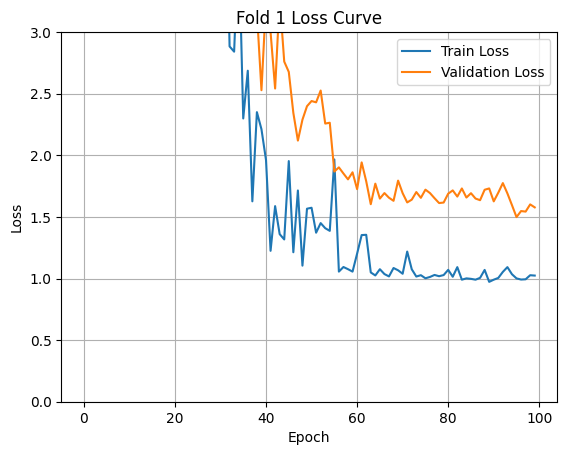

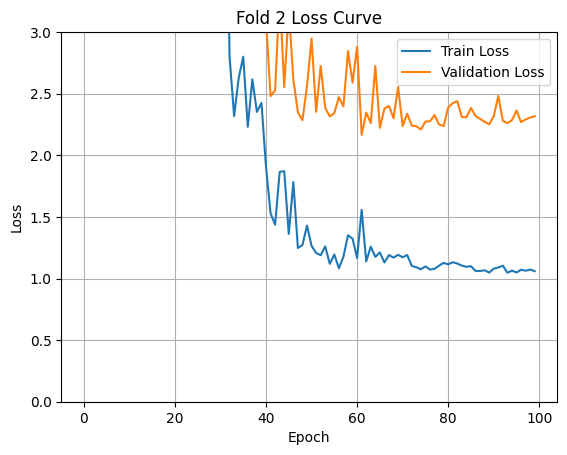

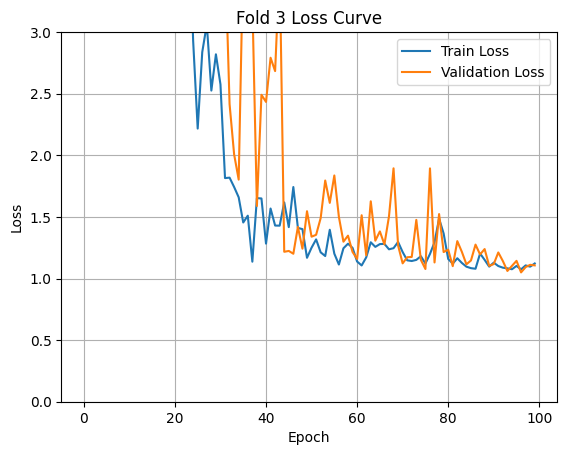

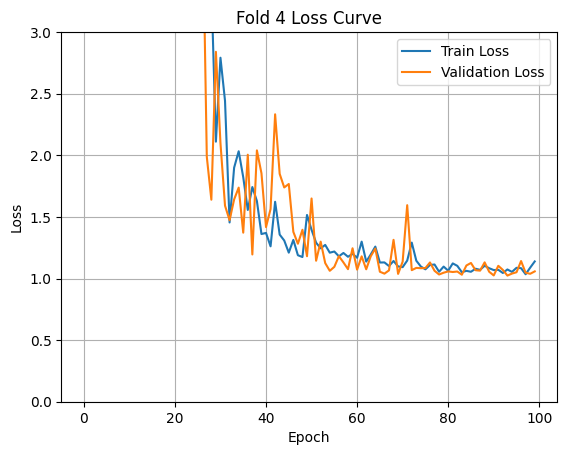

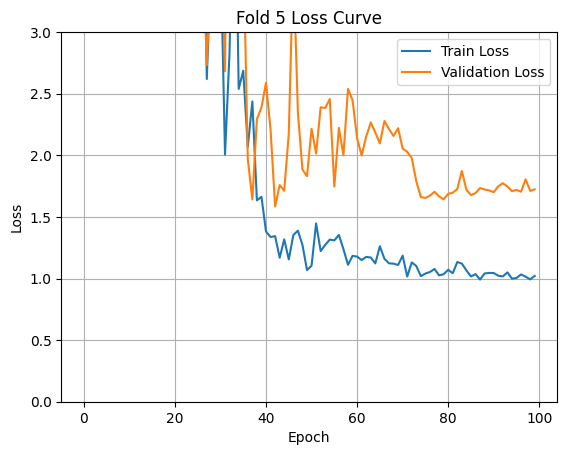

In [14]:
# Plot loss curves for each fold
for i in range(len(all_train_losses)):
    plt.figure()
    plt.plot(all_train_losses[i], label='Train Loss')
    plt.plot(all_val_losses[i], label='Validation Loss')
    plt.title(f"Fold {i+1} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0, 3)
    plt.legend()
    plt.grid(True)
    plt.show()

## 2-class

## PCA

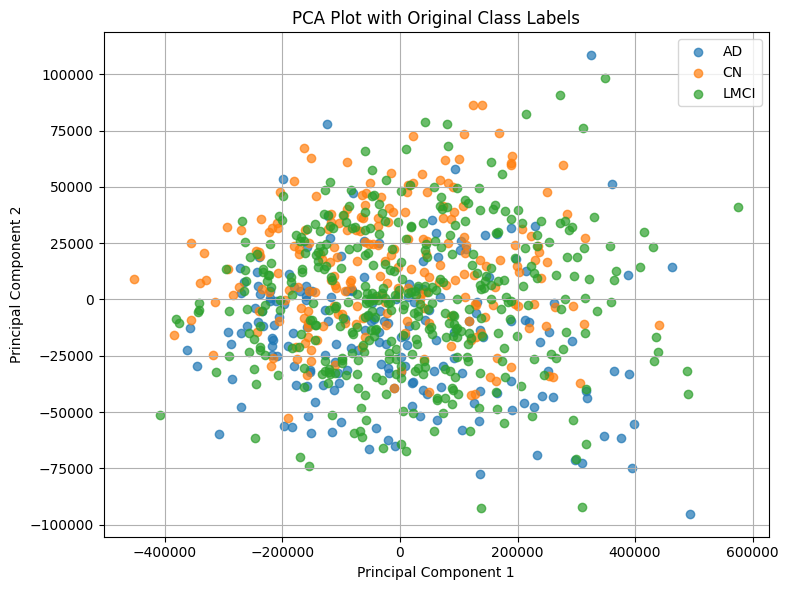

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting with original class names
plt.figure(figsize=(8, 6))
for class_label in np.unique(y_encoded):
    idx = y_encoded == class_label
    label_name = le.inverse_transform([class_label])[0]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label_name, alpha=0.7)

plt.title("PCA Plot with Original Class Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
